# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "_with_covars"
    / "gene_size_and_gene_density"
    / "gls-1000g_mashr-sub_corr"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_gene_density/gls-1000g_mashr-sub_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, check_n_lvs=True, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lvs = results["lv"].unique()
    n_observed_lvs = len(observed_lvs)
    if check_n_lvs:
        assert n_observed_lvs == 1
        observed_lv = observed_lvs[0]
    else:
        observed_lv = f"All LVs ({n_observed_lvs})"

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_gene_density/gls-1000g_mashr-sub_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_gene_density/gls-1000g_mashr-sub_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_gene_density/gls-1000g_mashr-sub_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_gene_density/gls-1000g_mashr-sub_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_gene_density/gls-1000g_mashr-sub_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV1,-0.007681,0.009581,-0.801721,0.422744,0.788628,random.pheno988
1,LV2,0.027292,0.012458,2.190743,0.028506,0.014253,random.pheno988
2,LV3,-0.011323,0.012298,-0.920731,0.357226,0.821387,random.pheno988
3,LV4,-0.014265,0.011957,-1.192997,0.232914,0.883543,random.pheno988
4,LV5,0.005343,0.012750,0.419074,0.675176,0.337588,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.06388753799392097

# QQ-plot

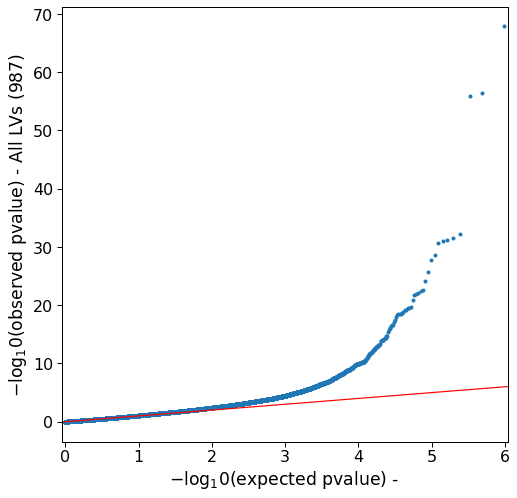

In [18]:
qqplot_unif(dfs, check_n_lvs=False)

# Summary of mean type I error per LV

In [19]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [20]:
summary_df.shape

(987, 4)

In [21]:
summary_df.head()

,lv,1,5,10
0,LV1,0.005,0.026,0.061
1,LV10,0.007,0.050,0.087
2,LV100,0.011,0.031,0.063
3,LV101,0.006,0.041,0.084
4,LV102,0.016,0.061,0.104


In [22]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.019072,0.063888,0.113290
std,0.017901,0.028182,0.035166
min,0.002000,0.015000,0.035000
25%,0.011000,0.049000,0.092000
50%,0.016000,0.059000,0.109000
75%,0.021000,0.071000,0.127000
max,0.244000,0.342000,0.403000


## LVs with expected type I error

In [23]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(68, 4)

,lv,1,5,10
288,LV359,0.009,0.049,0.085
947,LV952,0.018,0.049,0.082
443,LV499,0.010,0.049,0.099
511,LV56,0.012,0.049,0.096
395,LV455,0.011,0.049,0.090
394,LV454,0.014,0.049,0.095
380,LV441,0.010,0.049,0.097
372,LV434,0.008,0.049,0.077
364,LV427,0.012,0.049,0.098
315,LV383,0.012,0.049,0.105


,lv,1,5,10
841,LV857,0.019,0.051,0.112
407,LV466,0.012,0.051,0.095
917,LV925,0.019,0.051,0.092
48,LV142,0.015,0.051,0.093
857,LV871,0.011,0.051,0.101
253,LV327,0.014,0.051,0.083
791,LV811,0.016,0.051,0.094
496,LV546,0.015,0.051,0.095
277,LV349,0.014,0.051,0.095
282,LV353,0.012,0.051,0.095


## LVs with high type I error

In [24]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(461, 4)

,lv,1,5,10
129,LV215,0.076,0.166,0.223
710,LV739,0.075,0.166,0.231
153,LV237,0.086,0.173,0.247
423,LV480,0.083,0.173,0.255
349,LV413,0.106,0.178,0.230
906,LV915,0.104,0.181,0.244
255,LV329,0.137,0.183,0.212
682,LV713,0.104,0.189,0.250
965,LV969,0.107,0.190,0.267
401,LV460,0.111,0.192,0.251


# LVs with high mean type I error

In [25]:
lv_results_high = {}

## LV45

In [26]:
lv_code = "LV45"

In [27]:
results = dfs[dfs["lv"] == lv_code]

In [28]:
results.shape

(1000, 7)

In [29]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
44,LV45,0.017377,0.010313,1.684909,0.092055,0.046027,random.pheno988
1031,LV45,0.010524,0.010320,1.019765,0.307878,0.153939,random.pheno589
2018,LV45,0.005087,0.010317,0.493127,0.621940,0.310970,random.pheno385
3005,LV45,0.006544,0.010308,0.634834,0.525559,0.262779,random.pheno5
3992,LV45,-0.016299,0.010304,-1.581804,0.113743,0.943128,random.pheno74


In [30]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [31]:
show_prop(results, 0.01)

0.021

In [32]:
show_prop(results, 0.05)

0.063

In [33]:
show_prop(results, 0.10)

0.119

In [34]:
show_prop(results, 0.15)

0.164

In [35]:
show_prop(results, 0.20)

0.204

### QQplot

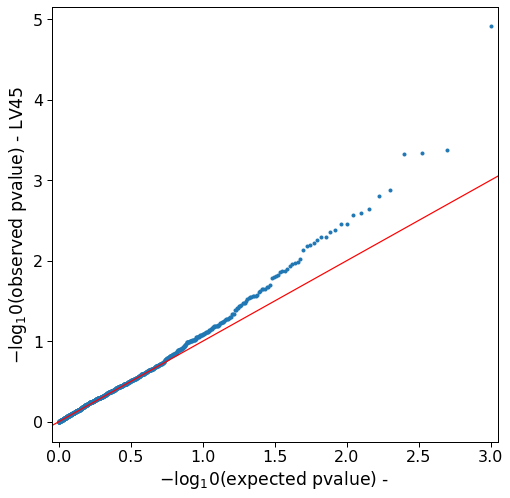

In [36]:
qqplot_unif(results)

## LV234

In [37]:
lv_code = "LV234"

In [38]:
results = dfs[dfs["lv"] == lv_code]

In [39]:
results.shape

(1000, 7)

In [40]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
233,LV234,0.019965,0.012366,1.614460,0.106477,0.053238,random.pheno988
1220,LV234,0.000056,0.012351,0.004515,0.996398,0.498199,random.pheno589
2207,LV234,-0.013162,0.012343,-1.066370,0.286297,0.856852,random.pheno385
3194,LV234,0.009505,0.012346,0.769861,0.441411,0.220705,random.pheno5
4181,LV234,0.002348,0.012374,0.189734,0.849524,0.424762,random.pheno74


In [41]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [42]:
show_prop(results, 0.01)

0.018

In [43]:
show_prop(results, 0.05)

0.061

In [44]:
show_prop(results, 0.10)

0.118

In [45]:
show_prop(results, 0.15)

0.148

In [46]:
show_prop(results, 0.20)

0.18

### QQplot

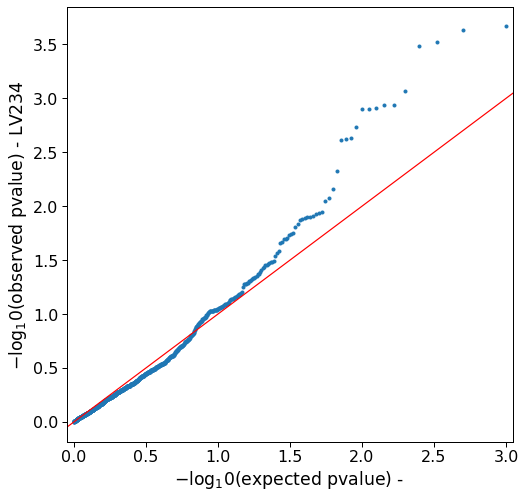

In [47]:
qqplot_unif(results)

## LV847

In [48]:
lv_code = "LV847"

In [49]:
results = dfs[dfs["lv"] == lv_code]

In [50]:
results.shape

(1000, 7)

In [51]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
846,LV847,0.009562,0.012905,0.740950,0.458751,0.229375,random.pheno988
1833,LV847,0.003336,0.012929,0.258003,0.796413,0.398206,random.pheno589
2820,LV847,-0.015324,0.012909,-1.187039,0.235256,0.882372,random.pheno385
3807,LV847,0.008010,0.012897,0.621048,0.534590,0.267295,random.pheno5
4794,LV847,0.007806,0.012949,0.602842,0.546635,0.273318,random.pheno74


In [52]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [53]:
show_prop(results, 0.01)

0.025

In [54]:
show_prop(results, 0.05)

0.061

In [55]:
show_prop(results, 0.10)

0.102

In [56]:
show_prop(results, 0.15)

0.14

In [57]:
show_prop(results, 0.20)

0.188

### QQplot

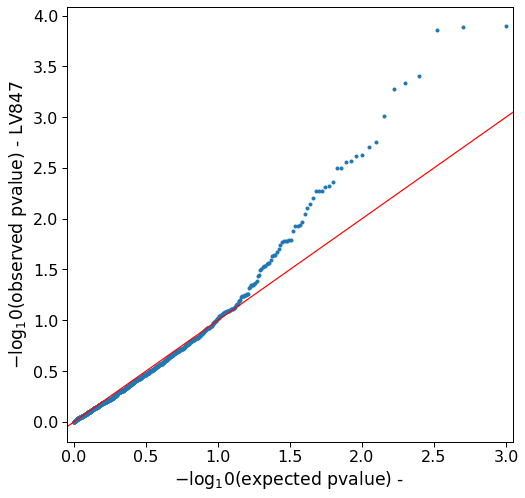

In [58]:
qqplot_unif(results)

## LV110

In [59]:
lv_code = "LV110"

In [60]:
results = dfs[dfs["lv"] == lv_code]

In [61]:
results.shape

(1000, 7)

In [62]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
109,LV110,-0.022768,0.013607,-1.673258,0.094325,0.952837,random.pheno988
1096,LV110,-0.008079,0.013619,-0.593166,0.553091,0.723455,random.pheno589
2083,LV110,-0.023882,0.013607,-1.755155,0.079280,0.960360,random.pheno385
3070,LV110,-0.010886,0.013570,-0.802215,0.422458,0.788771,random.pheno5
4057,LV110,-0.002395,0.013608,-0.176030,0.860276,0.569862,random.pheno74


In [63]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [64]:
show_prop(results, 0.01)

0.009

In [65]:
show_prop(results, 0.05)

0.034

In [66]:
show_prop(results, 0.10)

0.068

In [67]:
show_prop(results, 0.15)

0.11

In [68]:
show_prop(results, 0.20)

0.145

### QQplot

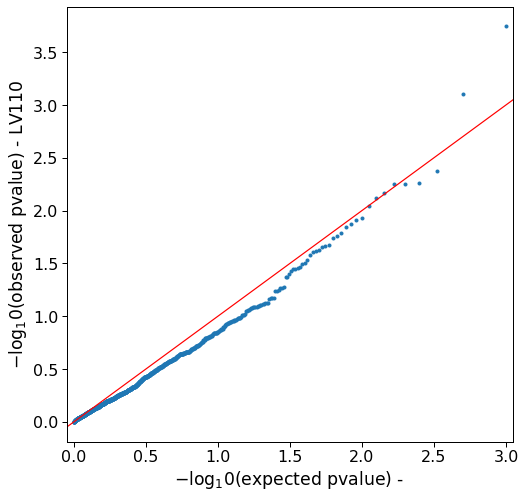

In [69]:
qqplot_unif(results)

## LV769

In [70]:
lv_code = "LV769"

In [71]:
results = dfs[dfs["lv"] == lv_code]

In [72]:
results.shape

(1000, 7)

In [73]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
768,LV769,0.014772,0.011846,1.246993,0.212445,0.106223,random.pheno988
1755,LV769,0.002259,0.011811,0.191251,0.848335,0.424168,random.pheno589
2742,LV769,0.002063,0.011827,0.174402,0.861555,0.430777,random.pheno385
3729,LV769,-0.015118,0.011825,-1.278424,0.201146,0.899427,random.pheno5
4716,LV769,-0.019823,0.011847,-1.673183,0.094340,0.952830,random.pheno74


In [74]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [75]:
show_prop(results, 0.01)

0.05

In [76]:
show_prop(results, 0.05)

0.142

In [77]:
show_prop(results, 0.10)

0.225

In [78]:
show_prop(results, 0.15)

0.289

In [79]:
show_prop(results, 0.20)

0.347

### QQplot

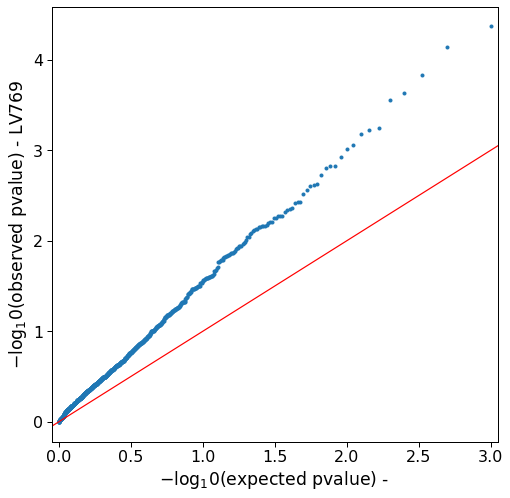

In [80]:
qqplot_unif(results)

## LV800

In [81]:
lv_code = "LV800"

In [82]:
results = dfs[dfs["lv"] == lv_code]

In [83]:
results.shape

(1000, 7)

In [84]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
799,LV800,0.007078,0.014089,0.502384,0.615414,0.307707,random.pheno988
1786,LV800,-0.006552,0.014092,-0.464924,0.642001,0.678999,random.pheno589
2773,LV800,-0.002879,0.014111,-0.204023,0.838342,0.580829,random.pheno385
3760,LV800,-0.023308,0.014124,-1.650201,0.098951,0.950525,random.pheno5
4747,LV800,-0.011711,0.014064,-0.832738,0.405024,0.797488,random.pheno74


In [85]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [86]:
show_prop(results, 0.01)

0.008

In [87]:
show_prop(results, 0.05)

0.049

In [88]:
show_prop(results, 0.10)

0.087

In [89]:
show_prop(results, 0.15)

0.137

In [90]:
show_prop(results, 0.20)

0.185

### QQplot

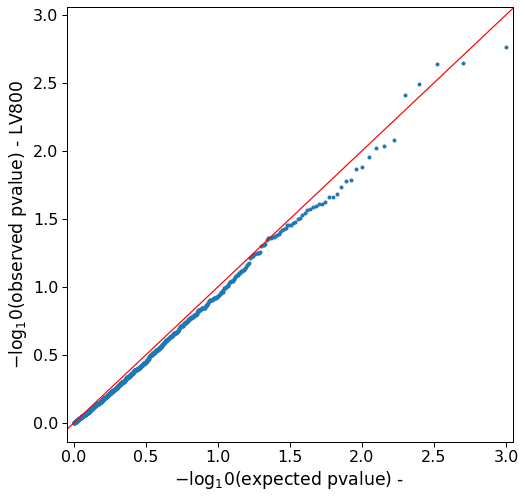

In [91]:
qqplot_unif(results)

# LVs with expected mean type I error

In [92]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
288,LV359,0.009,0.049,0.085
947,LV952,0.018,0.049,0.082
443,LV499,0.010,0.049,0.099
511,LV56,0.012,0.049,0.096
395,LV455,0.011,0.049,0.090
394,LV454,0.014,0.049,0.095
380,LV441,0.010,0.049,0.097
372,LV434,0.008,0.049,0.077
364,LV427,0.012,0.049,0.098
315,LV383,0.012,0.049,0.105


In [93]:
lv_results_expected = {}

## LV412

In [94]:
lv_code = "LV412"

In [95]:
results = dfs[dfs["lv"] == lv_code]

In [96]:
results.shape

(1000, 7)

In [97]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
411,LV412,0.002017,0.010537,0.191437,0.848189,0.424094,random.pheno988
1398,LV412,-0.002718,0.010492,-0.259057,0.795600,0.602200,random.pheno589
2385,LV412,0.002854,0.010484,0.272208,0.785471,0.392735,random.pheno385
3372,LV412,-0.004275,0.010546,-0.405395,0.685201,0.657400,random.pheno5
4359,LV412,0.016624,0.010492,1.584506,0.113128,0.056564,random.pheno74


In [98]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [99]:
show_prop(results, 0.01)

0.011

In [100]:
show_prop(results, 0.05)

0.053

In [101]:
show_prop(results, 0.10)

0.098

In [102]:
show_prop(results, 0.15)

0.15

In [103]:
show_prop(results, 0.20)

0.182

### QQplot

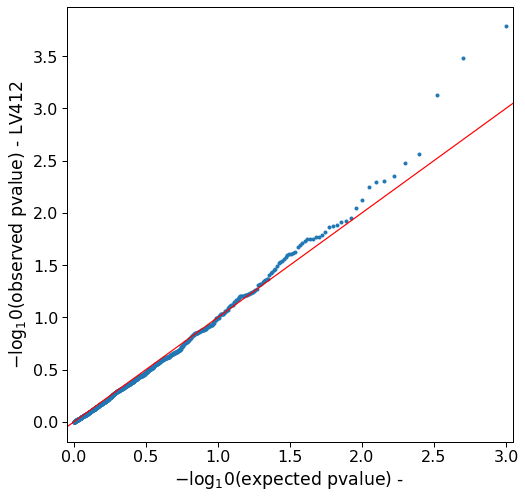

In [104]:
qqplot_unif(results)

## LV57

In [105]:
lv_code = "LV57"

In [106]:
results = dfs[dfs["lv"] == lv_code]

In [107]:
results.shape

(1000, 7)

In [108]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
56,LV57,-0.020082,0.012383,-1.621778,0.104900,0.947550,random.pheno988
1043,LV57,0.017050,0.012392,1.375944,0.168887,0.084443,random.pheno589
2030,LV57,0.018165,0.012394,1.465576,0.142813,0.071406,random.pheno385
3017,LV57,0.000877,0.012381,0.070803,0.943557,0.471778,random.pheno5
4004,LV57,0.013340,0.012354,1.079773,0.280284,0.140142,random.pheno74


In [109]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [110]:
show_prop(results, 0.01)

0.01

In [111]:
show_prop(results, 0.05)

0.058

In [112]:
show_prop(results, 0.10)

0.105

In [113]:
show_prop(results, 0.15)

0.14

In [114]:
show_prop(results, 0.20)

0.181

### QQplot

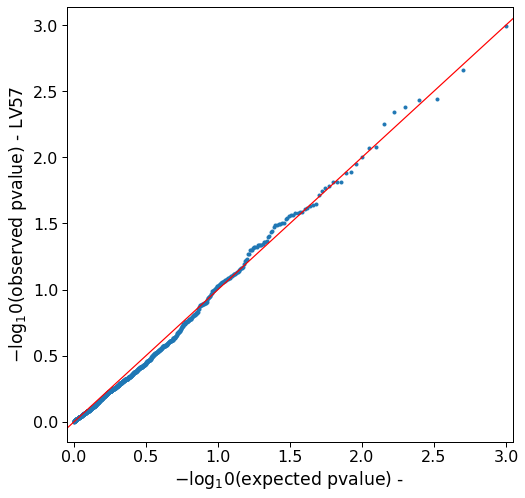

In [115]:
qqplot_unif(results)

## LV647

In [116]:
lv_code = "LV647"

In [117]:
results = dfs[dfs["lv"] == lv_code]

In [118]:
results.shape

(1000, 7)

In [119]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
646,LV647,-0.004828,0.011530,-0.418702,0.675448,0.662276,random.pheno988
1633,LV647,0.014454,0.011533,1.253297,0.210143,0.105072,random.pheno589
2620,LV647,0.012597,0.011531,1.092488,0.274659,0.137330,random.pheno385
3607,LV647,0.002939,0.011532,0.254827,0.798865,0.399433,random.pheno5
4594,LV647,0.014330,0.011505,1.245587,0.212962,0.106481,random.pheno74


In [120]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [121]:
show_prop(results, 0.01)

0.025

In [122]:
show_prop(results, 0.05)

0.072

In [123]:
show_prop(results, 0.10)

0.122

In [124]:
show_prop(results, 0.15)

0.167

In [125]:
show_prop(results, 0.20)

0.218

### QQplot

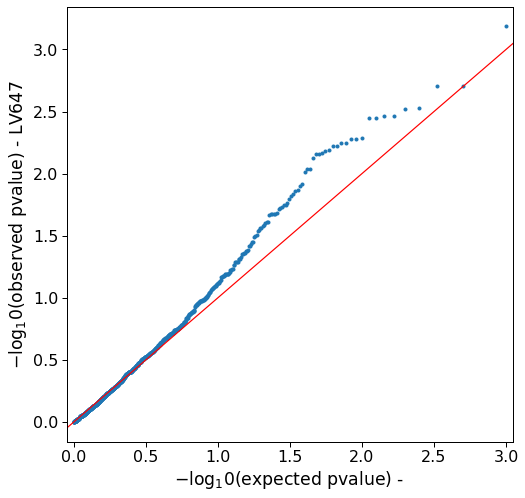

In [126]:
qqplot_unif(results)